# Toy example: fit mixture of von-Mises Fisher model to toy data 

## generate toy data from vMF mixture model using scipy
- 100 datapoints each from three components of a mixture of von-Mises Fisher distribution in $D=1000$.

In [1]:
from vMFne.logpartition import gradΦ
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(0) # reproducability

N = 300   # number of data points
D = 1000  # dimension of data points
K = 3     # number of mixture components (= # of clusters)

# ground-truth parameters in natural parametrization (for scipy von-Mise Fisher implementation)
weights = np.ones(K)/K
kappas = D/2 * np.linspace(0.5, 1.5, K)

# determine cluster assignments - we could sample, for simplicity determine from ratio of weights 
Ns = np.int32(np.round(N*weights))
K = len(weights)
class_true = np.concatenate([k * np.ones(Ns[k]) for k in range(K)])
ms = np.random.normal(size=(K,D))                   # directions for cluster centers
ms = ms / np.linalg.norm(ms,axis=-1).reshape(-1,1)  # (need to lie on hypersphere)

# sample from each mixture component in order
x_vmf = []
for Nk,mk,kappak in zip(Ns, ms, kappas):
    x_vmf.append(scipy.stats.vonmises_fisher(mu=mk, kappa=kappak, seed=0).rvs(Nk))
x_vmf = np.concatenate(x_vmf, axis=0)

print('(N,D) = ', x_vmf.shape)

(N,D) =  (300, 1000)


## Fit vMF mixture model to data using Bregman Clustering
Bregman Clustering is Expectation Maximization for mixtures of exponential family distributions in mean parametrziation. This involves the negative entropy function $\Psi(\mu) = \max_\eta \eta^\top{}\mu - \Phi(\eta)$, which is the Legendre transform of the better-known log-partition function $\Phi(\eta) = \log I_{D/2-1}(||\eta||) - (D/2-1) \log ||\eta||$ of the von-Mises Fisher distribution, where $D$ is the dimension of the distribution (data is assumed to be on the hypersphere $S^{D-1})$, and $\eta$ is the natural parameter. 

The negative entropy function $\Psi(\mu)$ and its derivatives are not known in closed form. We derived a second-order ODE whose solutions give $\Psi(\mu)$, $||\nabla\Psi(\mu)||$, which are all that is needed for Bregman clustering. 

In [2]:
# compute log-likelihood of data for true parameters for comparison with model fit
from vMFne.moVMF import  posterior_marginal_vMF_mixture_Φ

# compute cluster responsibilities p(k | x[n], \theta) and log p(x[n]) for each datapoint n given parameters \theta = {w, kappas, ms}
ph_x_μ_true_Φ, log_px_true_Φ = posterior_marginal_vMF_mixture_Φ(x_vmf,weights,kappas.reshape(-1,1)*ms)
LL_true = log_px_true_Φ.sum()


initial w: [0.33333333 0.33333333 0.33333333]
initial ||μs||: [0.26720604 0.24003463 0.25838852]
 #1/10
w: [0.38303247 0.48915403 0.12781349]
||μs||: [0.47453596 0.26342222 0.27167678]
 #2/10
w: [0.33333333 0.47776388 0.18890278]
||μs||: [0.54452685 0.27993198 0.24588551]
 #3/10
w: [0.33333333 0.3333343  0.33333236]
||μs||: [0.54452685 0.42737607 0.25850108]
 #4/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #5/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #6/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #7/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #8/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #9/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]
 #10/10
w: [0.33333333 0.33333333 0.33333333]
||μs||: [0.54452685 0.42737708 0.25850102]

 compute time was abo

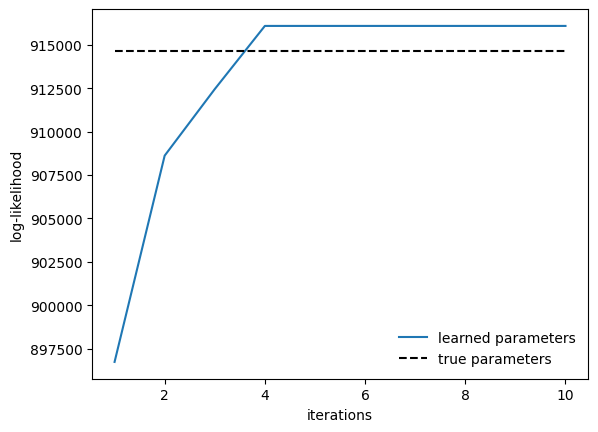

In [3]:
from vMFne.bregman_clustering import softBregmanClustering_vMF
import timeit
time_now = timeit.time.time

Ψ0 = [None, 0.0] # initial conditions for ODE to be solved for negative entropy and its gradients
                # Ψ0[0] = None will leave it to the method to compute the correct value
                # Ψ0[1] > 0.0 will numerically integrate the ODE with initial condition Ψ'(0) = Ψ0[1]
                # Ψ0[1] = 0.0 would lead to ill-defined initial condition, so we skip the ODE and return the closed-form approximation

t_start = time_now() # (rough) walltime estimate

# returns the mixture weights w, the compoment mean paramters μ_k = μs[k], and the log-likelihood over iterations LL. 
μs, w, LL = softBregmanClustering_vMF(X=x_vmf, 
                                      K=K, 
                                      max_iter=10, 
                                      w_init=None,   # will initialize component weights as 1/K 
                                      μs_init=None,  # will get initial μ_k from random partitioning of data 
                                      Ψ0=Ψ0, 
                                      verbose=True)

print('\n compute time was about ' + str(time_now() - t_start) + ' seconds')
# Note this is so fast because we don't solve the ODE  (Ψ0[1] = 0.0) !
# With solving the ODE (Ψ0[1] = 1e-4) this takes about 1 second per iteration (10s for full fit) on a desktop computer

plt.plot(np.arange(10)+1, LL)
plt.plot([1, 10], np.ones(2) * LL_true, 'k--')
plt.xlabel('iterations')
plt.ylabel('log-likelihood')
plt.legend(['learned parameters', 'true parameters'], frameon=False)
plt.show()

## evaluate results
- normalized mutual information scores between clusterings and confusion matrices, for true and estimated parameters

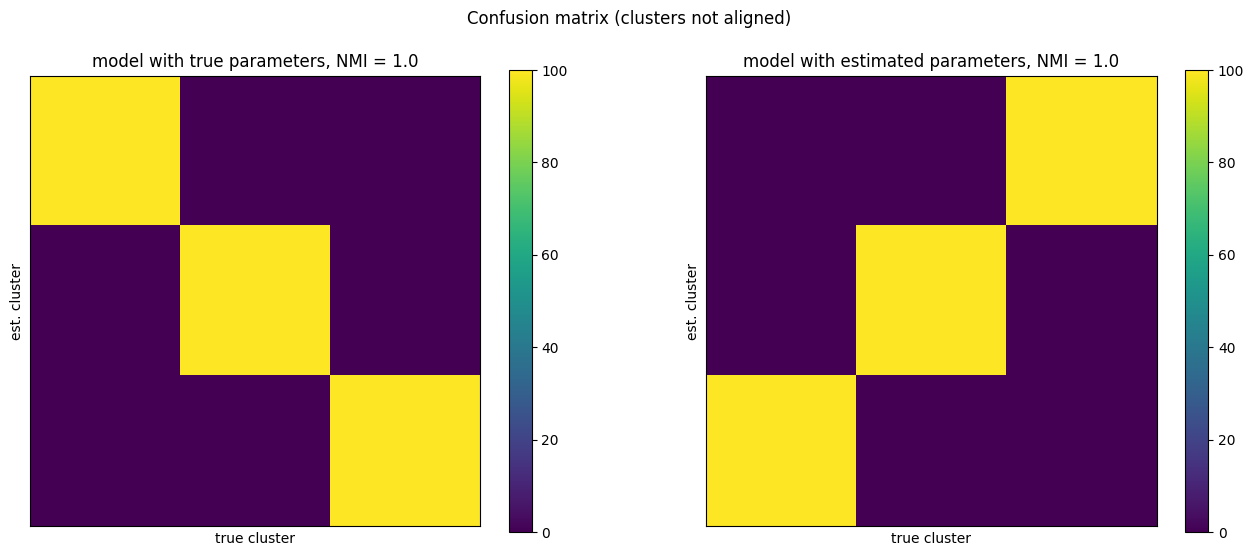

In [4]:
from vMFne.moVMF import posterior_marginal_vMF_mixture_Φ
from vMFne.bregman_clustering import posterior_marginal_vMF_mixture_Ψ
from sklearn import metrics
from sklearn.metrics import confusion_matrix

class_est_μ_true = np.argmax(ph_x_μ_true_Φ,axis=1)

ph_x_μ_est_Ψ, _ = posterior_marginal_vMF_mixture_Ψ(x_vmf,w, μs)
class_est_μ_est = np.argmax(ph_x_μ_est_Ψ,axis=1)

M_μ_true = confusion_matrix(class_true, class_est_μ_true)
M_μ_est = confusion_matrix(class_true, class_est_μ_est)

NMI_true_params = metrics.normalized_mutual_info_score(class_true.flatten(), class_est_μ_true.flatten())
NMI_est_params = metrics.normalized_mutual_info_score(class_true.flatten(), class_est_μ_est.flatten())

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(M_μ_true)
plt.colorbar()

plt.title('model with true parameters, NMI = ' + str(NMI_true_params))
plt.xticks([])
plt.yticks([])
plt.xlabel('true cluster')
plt.ylabel('est. cluster')

plt.subplot(1,2,2)
plt.imshow(M_μ_est)
plt.colorbar()
plt.ylabel('Norm. mutual information =' + str(metrics.normalized_mutual_info_score(class_true.flatten(), class_est_μ_est.flatten())))
plt.title('model with estimated parameters, NMI = ' + str(NMI_est_params))
plt.xticks([])
plt.yticks([])
plt.xlabel('true cluster')
plt.ylabel('est. cluster')

plt.suptitle('Confusion matrix (clusters not aligned)')
plt.show()